In [2]:
movie_features = load__movies_info()
user_features = load_users_info()
user_movie_ratings = load_user_movie_rating()

In [3]:
avg_score = user_movie_ratings.groupby("movie id").mean()['rating'].sort_values(ascending=False)
movie_features=pd.merge(movie_features,avg_score,on="movie id")

In [4]:
U_Mat = utility_matrix(user_movie_ratings)

In [5]:
# movie_pca, movie_k = reduce_movie_features(movie_features, k=3)
# user_pca, user_k = reduce_user_features(user_features, k=3)
movies = postprocess_movie(movie_features)
users  = postprocess_user(user_features)

In [6]:
movie_model, user_model = load_models()

In [7]:
with torch.no_grad():
    _, movie_k = movie_model(torch.from_numpy(movies).float())
    _, user_k = user_model(torch.from_numpy(users).float())

In [8]:
movie_k = movie_k.numpy()
user_k = user_k.numpy()

In [9]:
norm = np.linalg.norm(movie_k)
movie_k = movie_k/norm
norm = np.linalg.norm(user_k)
user_k = user_k/norm

In [41]:
std = 2

noise_var = 0.01 ** 2
res = []

violation = 0
reward = 0
total_step = 0
num_context = 0
total_reachable = 0


user_count = 0
for user_idx, row in U_Mat.iloc[::-1].iterrows():
    if user_count == 50:
        break
    user_count +=1
    ratings = np.nan_to_num(row.to_numpy())
    rated_idx = np.nonzero(ratings)
    
    parameters_set = []
    rating_look_up = {}
    for movie_idx in rated_idx[0]:

        v = movie_k[movie_idx].reshape(1, -1)
        u = user_k[user_idx - 1].reshape(1, -1)
        x = (v.T @ u).flatten()
#         print(x)
        rating_look_up[x.sum()] = ratings[movie_idx]
        parameters_set.append(x)
    parameters_set = np.stack(parameters_set)

    init_safe_movie, init_reward = np.argmax(ratings), np.max(ratings)  
    v = movie_k[init_safe_movie].reshape(1, -1)
    u = user_k[user_idx - 1].reshape(1, -1)
    x0 = (v.T @ u).flatten()
    y0 = rating_look_up[x0.sum()]
    
#     kernel = GPy.kern.Linear(225, variances=std**2)
    kernel = GPy.kern.RBF(input_dim=225, variance=std**2, lengthscale=.4, ARD=True)
    likelihood = GPy.likelihoods.gaussian.Gaussian(variance=noise_var)
    gp = GPy.core.GP(np.array([x0]), np.array([[y0]]), kernel, likelihood)
    opt = safeopt.SafeOpt(gp, parameters_set, fmin=3.0, lipschitz=None, threshold=0.2, beta=1)
    
    explored = [x0.sum()]

    
    count = 0
    for i in range(300):
        try:
            x_next = opt.optimize()
        except EnvironmentError:
            break
        count += 1
        reward += rating_look_up[x_next.sum()]
        if rating_look_up[x_next.sum()] < 3.0:
            violation += 1
#         print(x_next.sum(), reward)
        if x_next.sum() not in explored:
#             print(x_next.sum(), reward)
            explored.append(x_next.sum())
            

        
        opt.add_new_data_point(x_next, reward)
    total_step += i
    num_context += len(explored)
    total_reachable += len(np.where(ratings >= 3.0)[0])
    print(violation/total_step, reward / total_step, num_context / total_reachable, len(explored) / len(np.where(ratings >= 3.0)[0]))
    
#     res.append([violation / count, avg_reward / count, len(explored) / len(np.where(ratings > 3.0)[0])])
#     print('user:', str(user_idx), 'violation:', str(violation), 'avg reward', str(avg_reward / count), 'percent explored:', str(len(explored) / len(np.where(ratings > 3.0)[0])))


0.0 5.016722408026756 0.024193548387096774 0.024193548387096774
0.0 5.016722408026756 0.024752475247524754 0.02564102564102564
0.0 4.3478260869565215 0.03153153153153153 0.1
0.0 4.013377926421405 0.028846153846153848 0.022222222222222223
0.0 4.013377926421405 0.03081232492997199 0.044444444444444446
0.0 4.1806020066889635 0.02968036529680365 0.024691358024691357


KeyboardInterrupt: 

In [21]:
print(violation/total_step, reward / total_step, num_context / total_reachable)

0.12040133779264214 3.490969899665552 0.02529798102651423


Text(0.5, 1.0, 'Percentage of Safety Violation')

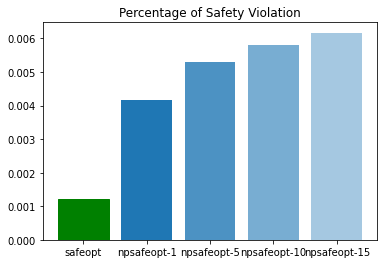

In [36]:
import matplotlib.pyplot as plt
barlist = plt.bar(["safeopt", "npsafeopt-1", 'npsafeopt-5', 'npsafeopt-10', 'npsafeopt-15']
        , [0.0012040133779264214, 0.004169314465506285, 0.0052971294732828585, 0.005792642140468227, 0.00617056856187291]
        , label='percentage violation')
barlist[0].set_color('g')
barlist[1].set_alpha(1)
barlist[2].set_alpha(0.8)
barlist[3].set_alpha(0.6)
barlist[4].set_alpha(0.4)
plt.title('Percentage of Safety Violation')

Text(0.5, 1.0, 'Avg Reward')

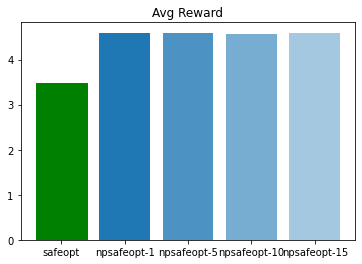

In [37]:
import matplotlib.pyplot as plt
barlist = plt.bar(["safeopt", "npsafeopt-1", 'npsafeopt-5', 'npsafeopt-10', 'npsafeopt-15']
        , [3.490969899665552, 4.5871448720531935, 4.595879405196362, 4.57438127090301, 4.591588628762541]
        , label='Avg Reward')
barlist[0].set_color('g')
barlist[1].set_alpha(1)
barlist[2].set_alpha(0.8)
barlist[3].set_alpha(0.6)
barlist[4].set_alpha(0.4)
plt.title('Avg Reward')

Text(0.5, 1.0, '% explored of the Reachable Set')

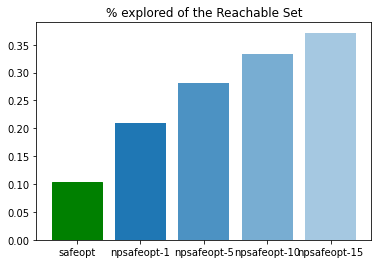

In [42]:
import matplotlib.pyplot as plt
barlist = plt.bar(["safeopt", "npsafeopt-1", 'npsafeopt-5', 'npsafeopt-10', 'npsafeopt-15']
        , [0.1029798102651423, 0.2104029304029304, 0.2813186813186813, 0.3333821733821734, 0.3716117216117216]
        )
barlist[0].set_color('g')
barlist[1].set_alpha(1)
barlist[2].set_alpha(0.8)
barlist[3].set_alpha(0.6)
barlist[4].set_alpha(0.4)
plt.title('% explored of the Reachable Set')

In [11]:
p_vio = np.stack(res)[:, 0]
avg_reward = np.stack(res)[:, 1]
p_explored = np.stack(res)[:, 2]

In [12]:
p_vio.mean(), p_vio.std()

(0.08280000000000001, 0.24596238194759243)

In [13]:
avg_reward.mean(), avg_reward.std()

(4.1844, 0.9464024138224124)

In [14]:
p_explored.mean(), p_explored.std()

(0.297199774278355, 0.25313628639537344)

In [42]:
std = 2

noise_var = 0.05 ** 2

for user_idx, row in U_Mat.iterrows():

    ratings = np.nan_to_num(row.to_numpy())
    rated_idx = np.nonzero(ratings)
    
    parameters_set = []
    rating_look_up = {}
    for movie_idx in rated_idx[0]:

        v = movie_k[movie_idx]
        u = user_k[user_idx - 1]
        x = np.dot(v, u)
        rating_look_up[x] = ratings[movie_idx]
        parameters_set.append(x)
    parameters_set = np.stack(parameters_set)
    
    parameters_set = parameters_set.reshape(-1, 1)

    init_safe_movie, init_reward = np.argmax(ratings), np.max(ratings)  
    v = movie_k[init_safe_movie]
    u = user_k[user_idx - 1]
    x0 = np.dot(v, u)
    y0 = rating_look_up[x0]
    
    
#     gp = GPy.models.GPRegression(x0, y0, kernel, noise_var=noise_var)
#     kernel = GPy.kern.Linear(400, variances=std**2)
    kernel = GPy.kern.RBF(input_dim=1, variance=std**2, lengthscale=.4, ARD=True)
    likelihood = GPy.likelihoods.gaussian.Gaussian(variance=noise_var)
    gp = GPy.core.GP(np.array([[x0]]), np.array([[y0]]), kernel, likelihood)
    opt = safeopt.SafeOpt(gp, parameters_set, fmin=2.5, lipschitz=None, threshold=2.5, beta=1.5)
    
    explored = [x0]
    avg_reward = 0
    violation = 0

    for i in range(300):
        x_next = opt.optimize()

        reward = rating_look_up[x_next[0]]
        
        if x_next.sum() not in explored:
#             print(x_next, reward)
            explored.append(x_next)
            avg_reward += reward
            if reward < 2.5:
                violation += 1
        
        opt.add_new_data_point(x_next, reward)

    print('user:', str(user_idx), 'violation:', str(violation), 'avg reward', str(avg_reward / len(explored) - 1), 'percent explored:', str(len(explored) / len(np.where(ratings > 2.5)[0])))
 

user: 1 violation: 1 avg reward 2.9285714285714284 percent explored: 0.0639269406392694
user: 2 violation: 3 avg reward 2.0 percent explored: 0.19298245614035087
user: 3 violation: 2 avg reward 1.625 percent explored: 0.26666666666666666
user: 4 violation: 1 avg reward 1.0 percent explored: 0.13043478260869565
user: 5 violation: 4 avg reward 2.4285714285714284 percent explored: 0.25225225225225223
user: 6 violation: 1 avg reward 2.789473684210526 percent explored: 0.10734463276836158
user: 7 violation: 1 avg reward 3.2142857142857144 percent explored: 0.07547169811320754
user: 8 violation: 2 avg reward 2.6923076923076925 percent explored: 0.26
user: 9 violation: 0 avg reward 2.3333333333333335 percent explored: 0.14285714285714285
user: 10 violation: 0 avg reward 3.3888888888888893 percent explored: 0.09782608695652174
user: 11 violation: 4 avg reward 2.56 percent explored: 0.15822784810126583
user: 12 violation: 0 avg reward 2.6666666666666665 percent explored: 0.12
user: 13 violation

OSError: There are no safe points to evaluate.

In [22]:

U_Mat.columns

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682],
           dtype='int64', name='movie id', length=1682)

In [13]:
U_Mat

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for user_idx, row in U_Mat.iterrows():
    
    ratings = np.nan_to_num(row.to_numpy())
    rated_idx = np.nonzero(ratings)
    
    # construct parameter sets, movie_k and user_k are training features. 
    # They are obtained other with a VAE or NMF. We use k=15
    parameters_set = []
    rating_look_up = {}
    for movie_idx in rated_idx[0]:
        v = movie_k[movie_idx].reshape(1, -1)
        u = user_k[user_idx - 1].reshape(1, -1)
        x = (v.T @ u).flatten()
        rating_look_up[x.sum()] = ratings[movie_idx]
        parameters_set.append(x) 
    parameters_set = np.stack(parameters_set)

    # init safe seed by picking a highest rated movie by the user
    init_safe_movie, init_reward = np.argmax(ratings), np.max(ratings)  
    v = movie_k[init_safe_movie].reshape(1, -1)
    u = user_k[user_idx - 1].reshape(1, -1)
    x0 = (v.T @ u).flatten()
    y0 = rating_look_up[x0.sum()]
    
    kernel = GPy.kern.Linear(225, variances=std**2)
    likelihood = GPy.likelihoods.gaussian.Gaussian(variance=noise_var)
    gp = GPy.core.GP(np.array([x0]), np.array([[y0]]), kernel, likelihood)
    opt = safeopt.SafeOpt(gp, parameters_set, fmin=2.5, lipschitz=None, threshold=0.2)
    
    
    for i in range(300):
        x_next = opt.optimize()
        reward = rating_look_up[x_next.sum()]       
        opt.add_new_data_point(x_next, reward)